##Predictive Maintenance for Manufacturing Assets

###BY SHIVANI UPPALA


In [1]:
# Cell 1: Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
import xgboost as xgb
from scipy import stats  # For outlier detection

In [2]:
# Set style for plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [4]:
#Cell 2: Load and inspect the dataset
df = pd.read_csv('/content/ai4i2020.csv')

In [5]:
print("Dataset shape:", df.shape)
print("\nFirst 5 rows:")
print(df.head())
print("\nDataset info:")
print(df.info())
print("\nSummary statistics:")
print(df.describe())

Dataset shape: (10000, 14)

First 5 rows:
   UDI Product ID Type  Air temperature [K]  Process temperature [K]  \
0    1     M14860    M                298.1                    308.6   
1    2     L47181    L                298.2                    308.7   
2    3     L47182    L                298.1                    308.5   
3    4     L47183    L                298.2                    308.6   
4    5     L47184    L                298.2                    308.7   

   Rotational speed [rpm]  Torque [Nm]  Tool wear [min]  Machine failure  TWF  \
0                    1551         42.8                0                0    0   
1                    1408         46.3                3                0    0   
2                    1498         49.4                5                0    0   
3                    1433         39.5                7                0    0   
4                    1408         40.0                9                0    0   

   HDF  PWF  OSF  RNF  
0    0    0   

In [6]:
# Cell 3: Check for missing values and duplicates
print("Missing values:\n", df.isnull().sum())
print("\nDuplicates:", df.duplicated().sum())

Missing values:
 UDI                        0
Product ID                 0
Type                       0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
Machine failure            0
TWF                        0
HDF                        0
PWF                        0
OSF                        0
RNF                        0
dtype: int64

Duplicates: 0


In [7]:
# Drop duplicates if any (unlikely, but good practice)
df = df.drop_duplicates()

In [8]:
# Cell 4: Target variable analysis (Machine failure)
failure_rate = df['Machine failure'].value_counts(normalize=True) * 100
print("Failure rate distribution (%):")
print(failure_rate)

Failure rate distribution (%):
Machine failure
0    96.61
1     3.39
Name: proportion, dtype: float64


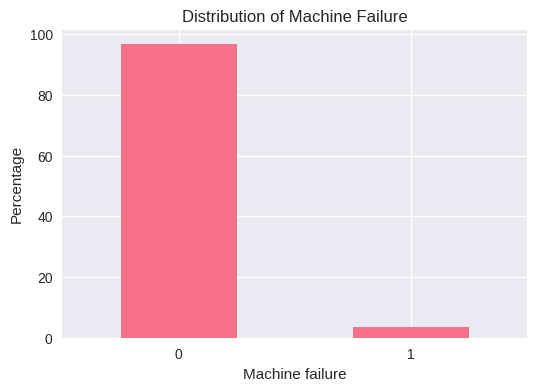

In [9]:
plt.figure(figsize=(6, 4))
failure_rate.plot(kind='bar')
plt.title('Distribution of Machine Failure')
plt.ylabel('Percentage')
plt.xticks(rotation=0)
plt.show()

In [10]:
# Check imbalance: This dataset is imbalanced (mostly non-failures)
print(f"Imbalance ratio (failure:non-failure): {len(df[df['Machine failure'] == 1]) / len(df[df['Machine failure'] == 0]):.4f}")

Imbalance ratio (failure:non-failure): 0.0351


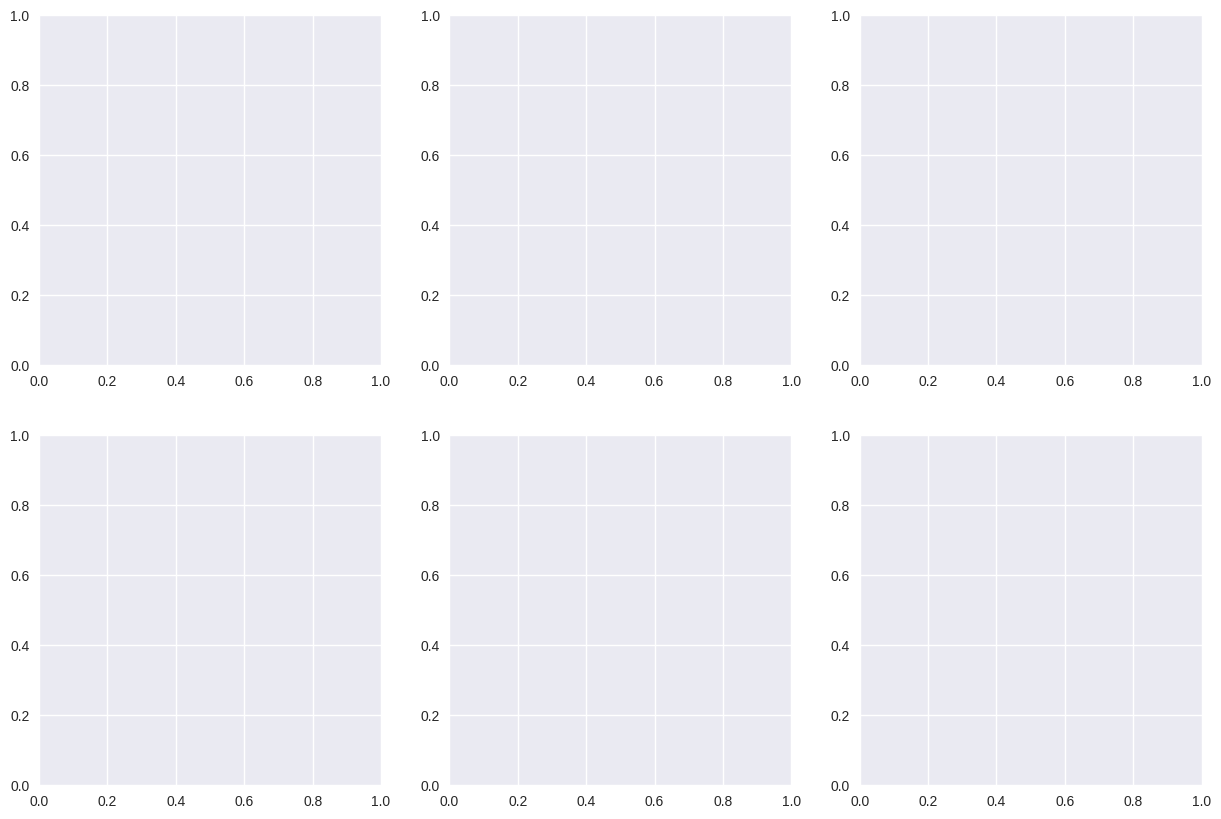

In [11]:
# Cell 5: Distributions of key features (histograms)
key_features = ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

In [12]:
for idx, feature in enumerate(key_features):
    axes[idx].hist(df[feature], bins=30, alpha=0.7, edgecolor='black')
    axes[idx].set_title(f'Distribution of {feature}')
    axes[idx].set_xlabel(feature)
    axes[idx].set_ylabel('Frequency')

In [13]:
plt.tight_layout()
plt.show()

<Figure size 800x550 with 0 Axes>

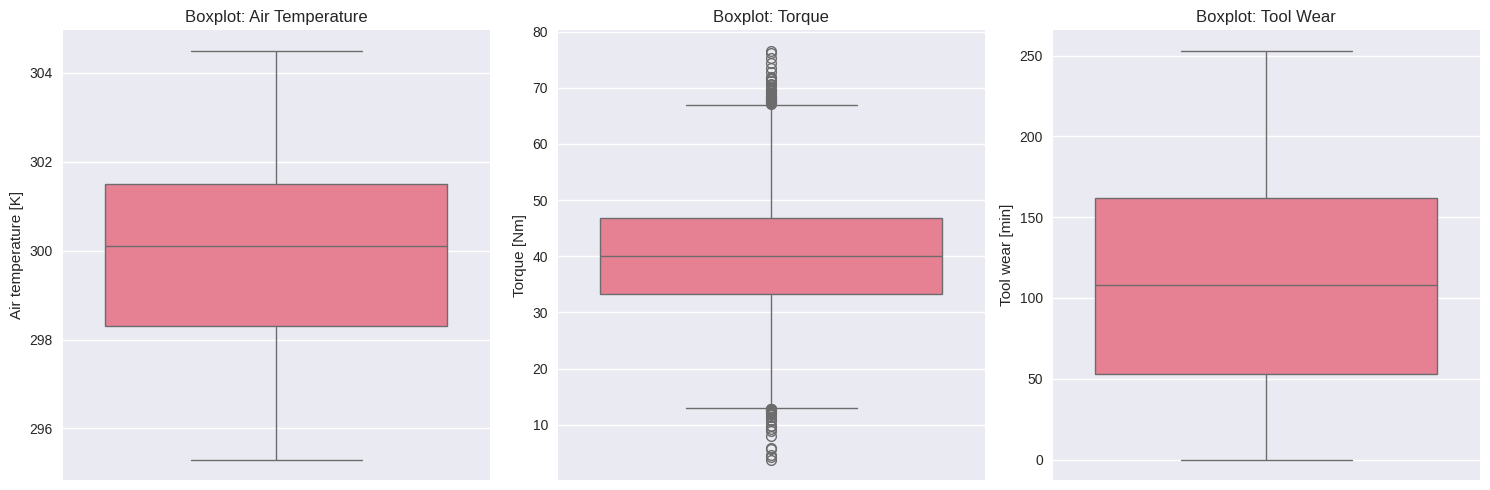

In [14]:
# Cell 6: Outlier detection using boxplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

sns.boxplot(data=df, y='Air temperature [K]', ax=axes[0])
axes[0].set_title('Boxplot: Air Temperature')

sns.boxplot(data=df, y='Torque [Nm]', ax=axes[1])
axes[1].set_title('Boxplot: Torque')

sns.boxplot(data=df, y='Tool wear [min]', ax=axes[2])
axes[2].set_title('Boxplot: Tool Wear')

plt.tight_layout()
plt.show()

In [15]:
 # Quantify outliers (using IQR method)
def detect_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return len(outliers)

In [16]:
for feature in key_features:
    outlier_count = detect_outliers(df, feature)
    print(f"Outliers in {feature}: {outlier_count} ({outlier_count / len(df) * 100:.2f}%)")

Outliers in Air temperature [K]: 0 (0.00%)
Outliers in Process temperature [K]: 0 (0.00%)
Outliers in Rotational speed [rpm]: 418 (4.18%)
Outliers in Torque [Nm]: 69 (0.69%)
Outliers in Tool wear [min]: 0 (0.00%)


In [17]:
# Cell 7: Correlation matrix and heatmap
# Select numeric features
numeric_df = df[key_features + ['Machine failure']]

In [18]:
corr_matrix = numeric_df.corr()

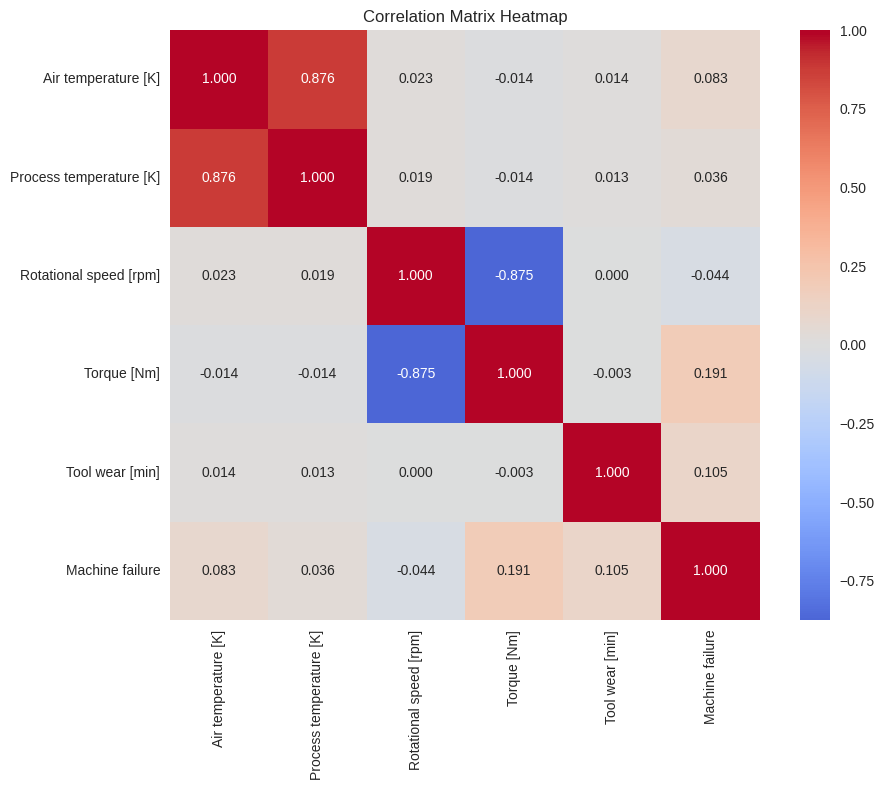

In [19]:
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, square=True, fmt='.3f')
plt.title('Correlation Matrix Heatmap')
plt.tight_layout()
plt.show()

In [20]:
# Print high correlations with target
target_corr = corr_matrix['Machine failure'].sort_values(ascending=False)
print("Correlations with Machine Failure:")
print(target_corr)

Correlations with Machine Failure:
Machine failure            1.000000
Torque [Nm]                0.191321
Tool wear [min]            0.105448
Air temperature [K]        0.082556
Process temperature [K]    0.035946
Rotational speed [rpm]    -0.044188
Name: Machine failure, dtype: float64


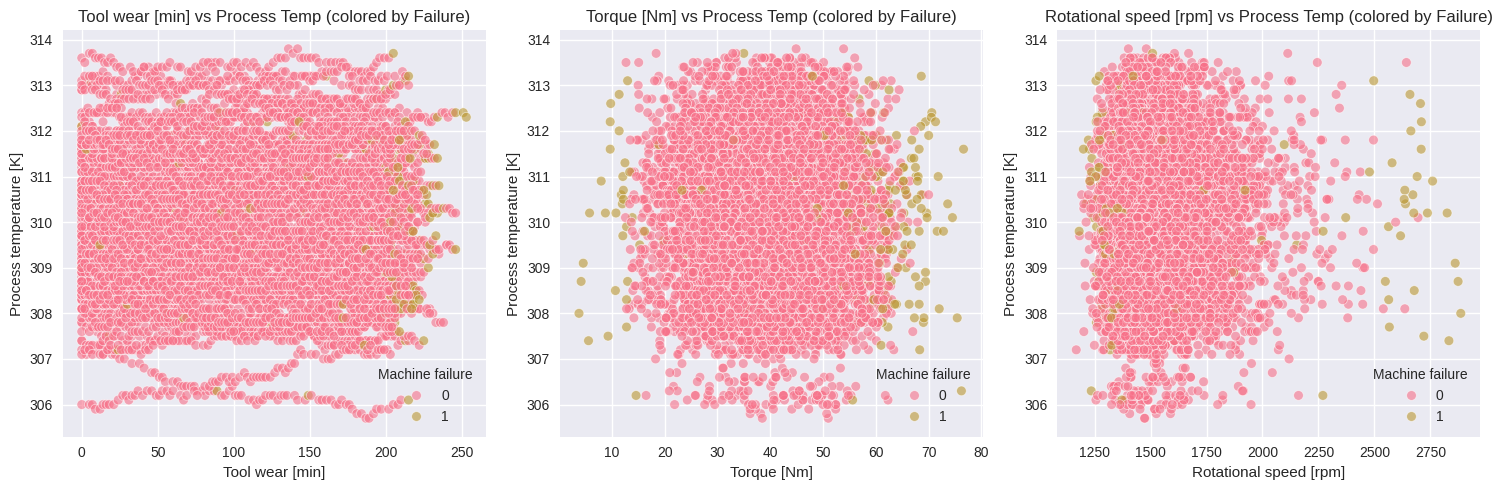

In [21]:
# Cell 8: Feature-target relationships (scatter plots for top correlated features)
top_corr_features = ['Tool wear [min]', 'Torque [Nm]', 'Rotational speed [rpm]']  # Based on correlations

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for idx, feature in enumerate(top_corr_features):
    sns.scatterplot(data=df, x=feature, y='Process temperature [K]', hue='Machine failure', alpha=0.6, ax=axes[idx])
    axes[idx].set_title(f'{feature} vs Process Temp (colored by Failure)')

plt.tight_layout()
plt.show()

In [22]:
# Cell 9: Failure type analysis (multi-label, but treat as separate binaries)
failure_types = ['TWF', 'HDF', 'PWF', 'OSF', 'RNF']
print("Failure type rates (%):")
for col in failure_types:
    rate = df[col].sum() / len(df) * 100
    print(f"{col}: {rate:.2f}%")

Failure type rates (%):
TWF: 0.46%
HDF: 1.15%
PWF: 0.95%
OSF: 0.98%
RNF: 0.19%


In [23]:
# Co-occurrence heatmap for failure types
failure_df = df[failure_types]
failure_corr = failure_df.corr()

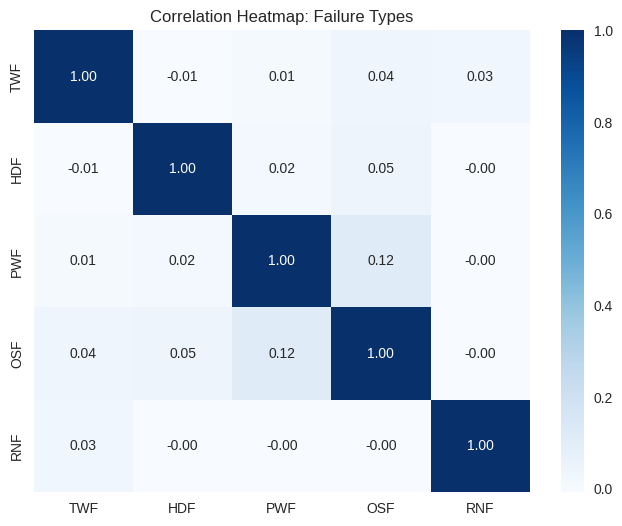

In [24]:
plt.figure(figsize=(8, 6))
sns.heatmap(failure_corr, annot=True, cmap='Blues', fmt='.2f')
plt.title('Correlation Heatmap: Failure Types')
plt.show()

In [25]:
# Cell 10: ML Pipeline - XGBoost for Binary Failure Prediction
# Prepare features and target
X = df[key_features]  # Use key numeric features
y = df['Machine failure']

In [26]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [27]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [28]:
# Train XGBoost model
model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', random_state=42)
model.fit(X_train_scaled, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [29]:
# Predictions
y_pred = model.predict(X_test_scaled)
y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]

In [30]:
# Evaluation
accuracy = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_proba)
print(f"Model Accuracy: {accuracy:.4f}")
print(f"ROC-AUC Score: {auc:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Model Accuracy: 0.9840
ROC-AUC Score: 0.9741

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1932
           1       0.83      0.66      0.74        68

    accuracy                           0.98      2000
   macro avg       0.91      0.83      0.86      2000
weighted avg       0.98      0.98      0.98      2000



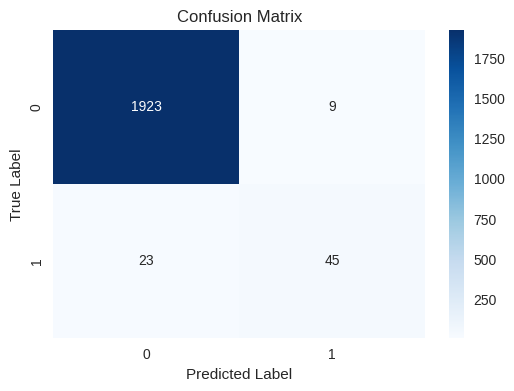

In [31]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

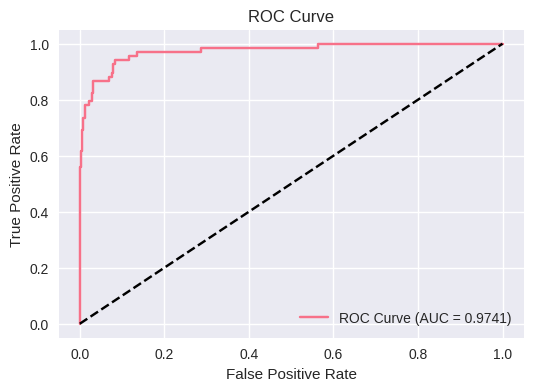

In [32]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

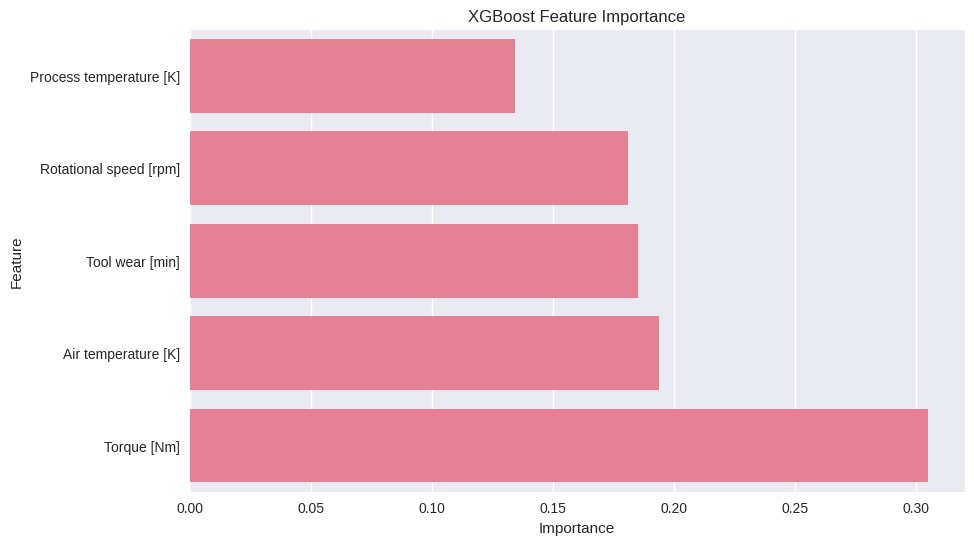

In [33]:
# Cell 11: Feature Importance Heatmap (from XGBoost)
importances = model.feature_importances_
importance_df = pd.DataFrame({'Feature': key_features, 'Importance': importances}).sort_values('Importance', ascending=True)

plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df, x='Importance', y='Feature')
plt.title('XGBoost Feature Importance')
plt.show()

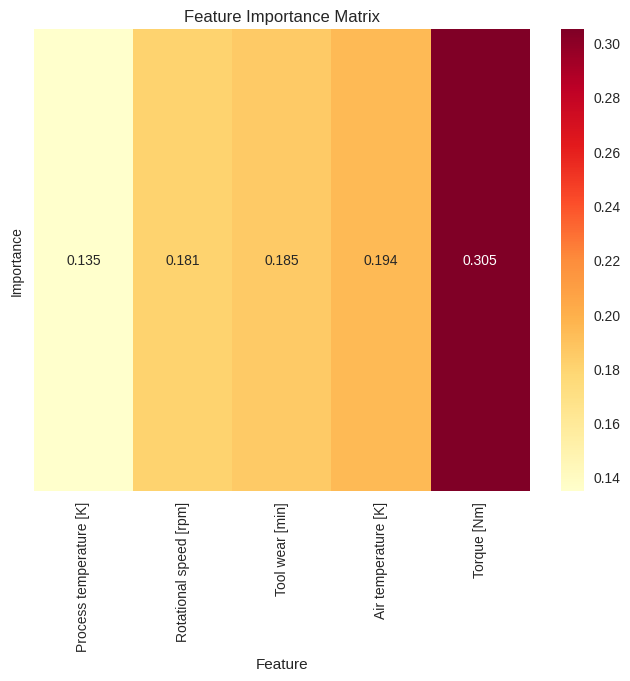

In [34]:
# Heatmap-style for importances (alternative visualization)
plt.figure(figsize=(8, 6))
sns.heatmap(importance_df.set_index('Feature').T, annot=True, cmap='YlOrRd', fmt='.3f')
plt.title('Feature Importance Matrix')
plt.show()

In [35]:
# Cell 12: Additional Analysis - Z-score for anomalies (simple statistical detection)
# Example: Detect anomalies in Torque using Z-score (>3 std devs)
df['Torque_Z'] = np.abs(stats.zscore(df['Torque [Nm]']))
anomalies = df[df['Torque_Z'] > 3]
print(f"Potential anomalies in Torque: {len(anomalies)}")

Potential anomalies in Torque: 25


In [36]:
if len(anomalies) > 0:
    print("Anomalies sample:")
    print(anomalies[['Torque [Nm]', 'Machine failure']].head())

Anomalies sample:
     Torque [Nm]  Machine failure
50           4.6                1
463          4.2                1
603         71.6                1
847          5.6                1
880         76.2                1
